# LSTM autoencoder를 이용한 시계열 data 이상 감지

시계열 자료의 이상치 검출

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dropout, Dense, RepeatVector
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

## Load the data

비정상적인 동작 기간이 labeling 된  인공 시계열 데이터
[Numenta Anomaly Benchmark(NAB)](
https://www.kaggle.com/boltzmannbrain/nab) 를 사용합니다. 데이터는 정열되고 타임스탬프가 지정된 단일 값 메트릭입니다.

학습에는 noise가 포함된 정상 시계열 데이터인인 `art_daily_small_noise.csv` 파일을 사용하고 테스트에는 이상치가 포함된 `art_daily_jumpsup.csv` 파일을 사용합니다. 이 데이터 세트의 단순성 덕분에 이상 탐지를 효과적으로 시연할 수 있습니다.

In [2]:
# 데이터셋의 기본 URL을 설정합니다.
master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

# 정상 데이터 URL 접미사를 설정합니다.
df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"

# 정상 데이터의 전체 URL을 생성합니다.
df_small_noise_url = master_url_root + df_small_noise_url_suffix

# 정상 데이터(훈련 세트)를 불러옵니다.
# parse_dates=True를 사용하여 'timestamp' 열을 날짜 형식으로 파싱합니다.
# index_col="timestamp"를 사용하여 'timestamp' 열을 인덱스로 설정합니다.
df_small_noise = pd.read_csv(df_small_noise_url, parse_dates=True, index_col="timestamp")

# 비정상 데이터 URL 접미사를 설정합니다.
df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"

# 비정상 데이터의 전체 URL을 생성합니다.
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix

# 비정상 데이터(테스트 세트)를 불러옵니다.
# parse_dates=True를 사용하여 'timestamp' 열을 날짜 형식으로 파싱합니다.
# index_col="timestamp"를 사용하여 'timestamp' 열을 인덱스로 설정합니다.
df_daily_jumpsup = pd.read_csv(df_daily_jumpsup_url, parse_dates=True, index_col="timestamp")

# 정상 데이터와 비정상 데이터의 형태(shape)를 출력합니다.
print(df_small_noise.shape, df_daily_jumpsup.shape)

(4032, 1) (4032, 1)


In [3]:
df_small_noise.head()

,value
timestamp,
2014-04-01 00:00:00,18.324919
2014-04-01 00:05:00,21.970327
2014-04-01 00:10:00,18.624806
2014-04-01 00:15:00,21.953684
2014-04-01 00:20:00,21.909120


In [4]:
df_daily_jumpsup.head()

,value
timestamp,
2014-04-01 00:00:00,19.761252
2014-04-01 00:05:00,20.500833
2014-04-01 00:10:00,19.961641
2014-04-01 00:15:00,21.490266
2014-04-01 00:20:00,20.187739


## data 시각화
### 정상 시계열 데이터

- 정상 데이터를 autoencoder 훈련에 사용합니다.

<Axes: xlabel='timestamp'>

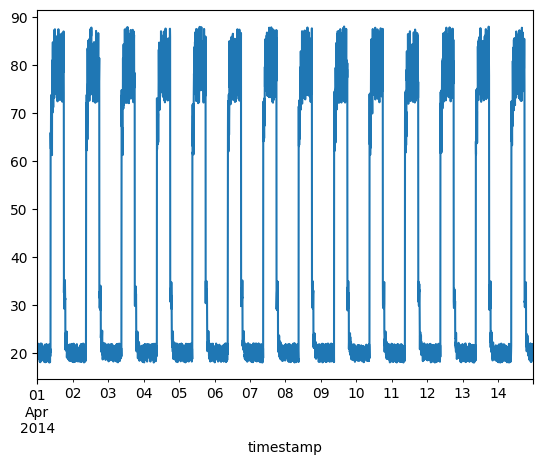

In [5]:
df_small_noise.plot(legend=False)

### 이상이 있는 시계열 데이터

정상 데이터로 훈련된 autoencoder 모델의 테스트를 위해 다음 데이터를 사용하고, 데이터의 갑작스러운 점프가 이상으로 감지되는지 확인합니다.

<Axes: xlabel='timestamp'>

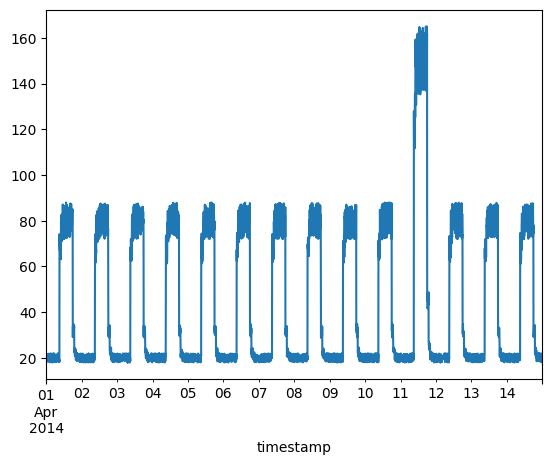

In [6]:
df_daily_jumpsup.plot(legend=False)

## 훈련 데이터 준비

훈련 시계열 데이터 파일(`df_small_noise`)에서 데이터 값을 가져오고 `value` 데이터를 정규화 합니다. 14일 동안 5분마다 `value`가 있습니다.

-   24시간 * 60분 / 5분 = **288 timesteps per day**
-   288 timesteps per day * 14일 = **total 4032 data points**

In [7]:
# 테스트 데이터를 정규화하기 위해 평균과 표준 편차를 정규화하고 저장합니다.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
# standard scaling
df_training_value = (df_small_noise - training_mean) / training_std

print("훈련 샘플 수:", len(df_training_value))

훈련 샘플 수: 4032


In [8]:
# normalize된 df_small_noise
df_training_value.head()

,value
timestamp,
2014-04-01 00:00:00,-0.858829
2014-04-01 00:05:00,-0.728993
2014-04-01 00:10:00,-0.848148
2014-04-01 00:15:00,-0.729586
2014-04-01 00:20:00,-0.731173


### 시퀀스 data 생성

훈련 데이터에서 `TIME_STEPS` 연속 데이터 값을 조합하여 시퀀스를 생성합니다.

In [9]:
TIME_STEPS = 288

# 모델에서 사용하기 위해 생성된 훈련 시퀀스
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

X_train = create_sequences(df_training_value.values)
print("Training input shape: ", X_train.shape)

Training input shape:  (3745, 288, 1)


## LSTM Autoencoder model


<img src="https://www.researchgate.net/profile/Hoang_Duy_Trinh2/publication/336594630/figure/fig2/AS:814792885420033@1571273170513/LSTM-Autoencoder-for-Anomaly-Detection.png" width=400 />

- RepeatVector 이해  

<img src="https://i.stack.imgur.com/LNXjF.jpg" width=400 />

| 구분               | return\_sequences=True          | RepeatVector                  |
| ---------------- | ------------------------------- | ----------------------------- |
| 역할               | LSTM이 모든 타임스텝의 출력을 반환           | 하나의 벡터를 여러 타임스텝으로 반복          |
| Encoder에서 주로 사용? | ❌ (보통 False로 해서 마지막 state만 씀)   | ✅ (잠재차원 z를 Decoder 입력 형태로 준비)             |
| 출력 형태            | (batch, timesteps, latent\_dim) | (batch, timesteps, latent\_dim)       |
| 목적               | Encoder가 "시퀀스 형태"의 특성을 유지할 때    | Decoder가 "시퀀스 형태" 입력을 필요로 할 때 |


In [32]:
from tensorflow.keras.layers import Bidirectional

# 시퀀셜 모델을 생성합니다.
model = Sequential()

# 첫 번째 LSTM 레이어를 추가합니다.
# 유닛 수는 32, 입력 형태는 (시퀀스 길이, 특성 수)로 설정합니다.
model.add(Bidirectional(LSTM(32), input_shape=(X_train.shape[1], X_train.shape[2])))

# 드롭아웃 레이어를 추가하여 과적합을 방지합니다.
model.add(Dropout(0.2))

# RepeatVector 레이어를 추가하여 인코더의 출력 길이를 시퀀스 길이로 반복합니다.
model.add(RepeatVector(X_train.shape[1]))

# 드롭아웃 레이어를 추가하여 과적합을 방지합니다.
model.add(Dropout(0.2))

# 두 번째 LSTM 레이어를 추가합니다.
# 유닛 수는 32, 모든 시퀀스를 출력하도록 설정(return_sequences=True)합니다.
model.add(Bidirectional(LSTM(32, return_sequences=True)))

# Dense 레이어를 추가하여 출력 형태를 (시퀀스 길이, 특성 수)로 맞춥니다.
model.add(Dense(X_train.shape[2]))

# 원하는 learning rate를 설정합니다.
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 64)             │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_3 (RepeatVector)  │ (None, 288, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 288, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 288, 64)        │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 288, 1)         │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,601 (131.25 KB)

 Trainable params: 33,601 (131.25 KB)

 Non-trainable params: 0 (0.00 B)

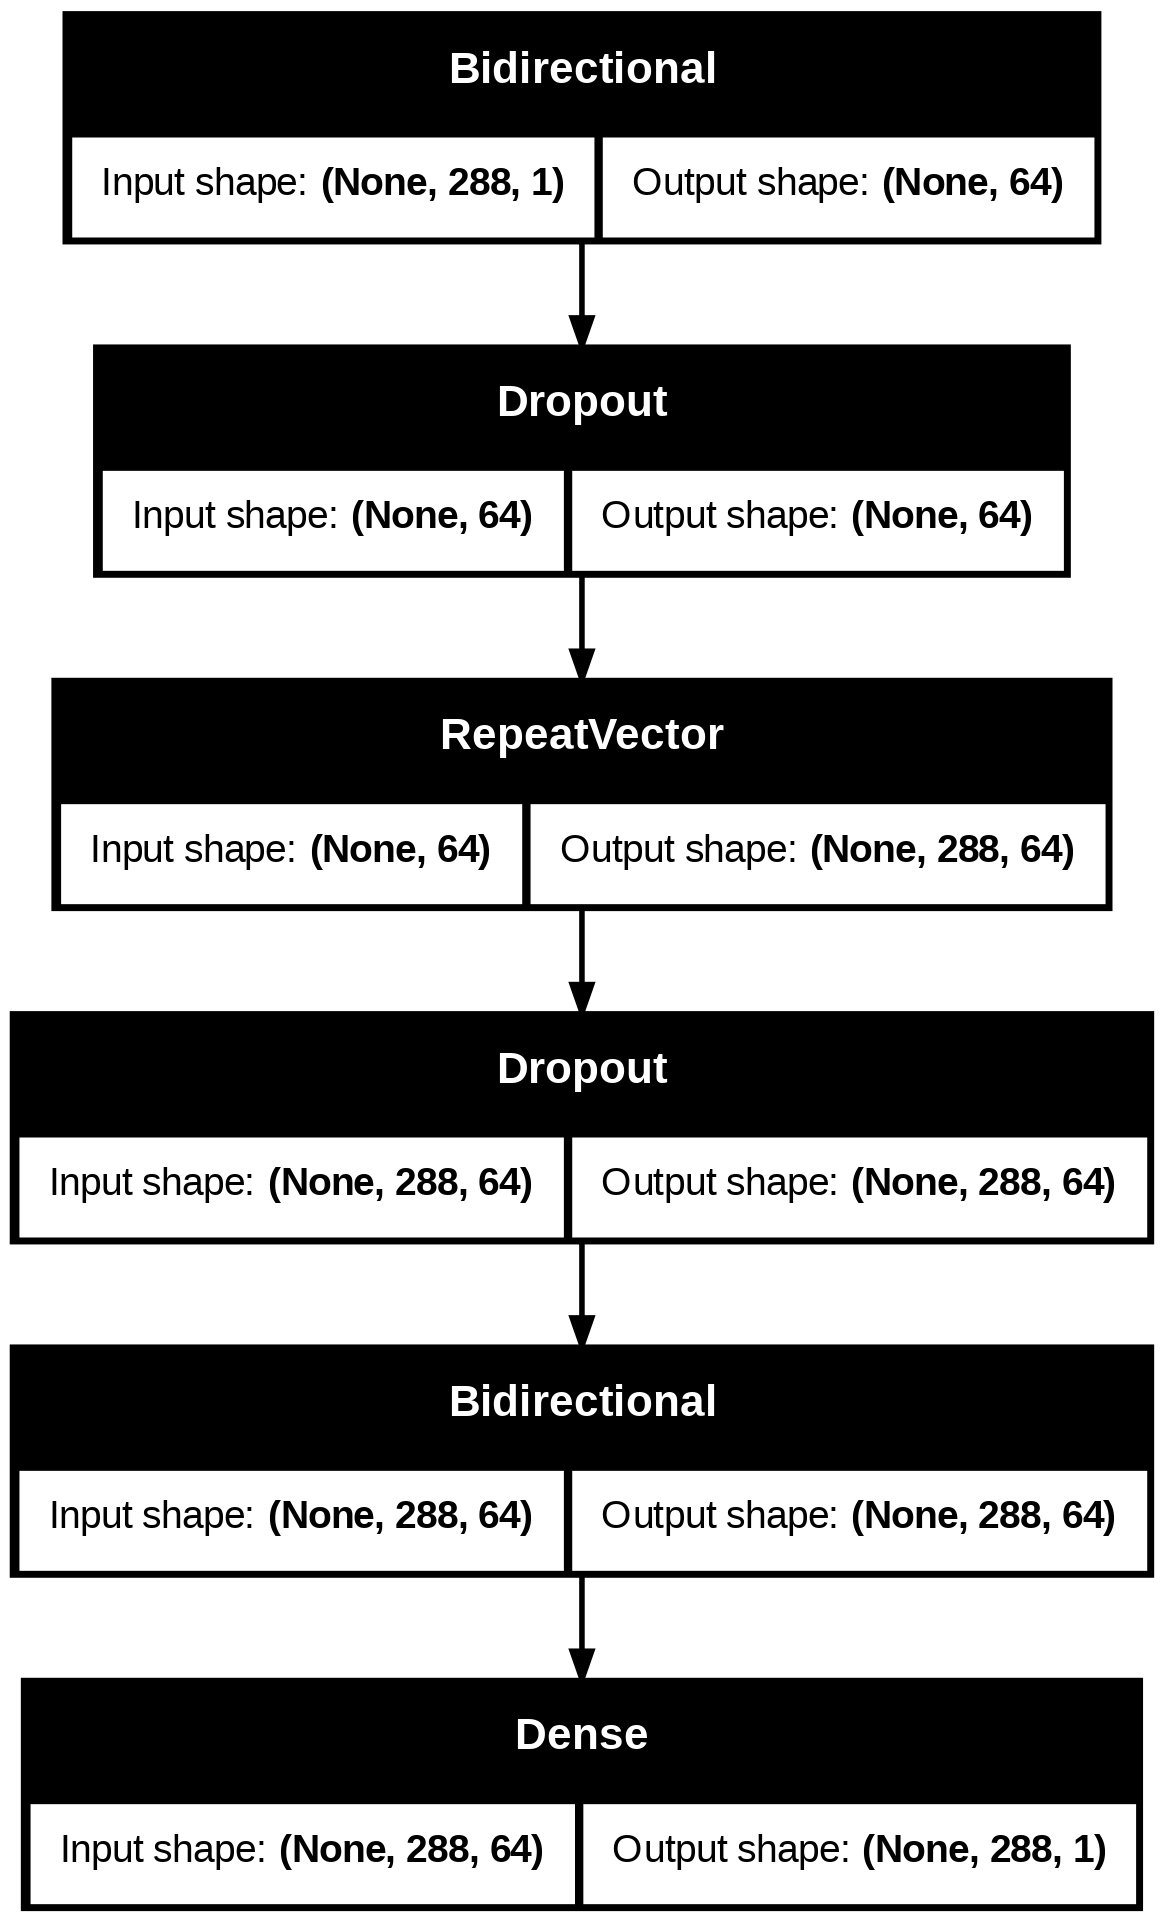

In [33]:
plot_model(model, show_shapes=True)

## 모델 train

재구성 모델이기 때문에 Input과 Target 모두 `X_train`을 사용합니다.

In [34]:
# 1. 시계열 데이터 분할
split_idx = int(len(X_train) * 0.9)  # 마지막 10%를 검증 세트로 사용
X_tr, X_val = X_train[:split_idx], X_train[split_idx:]

# 2. 모델 학습 (shuffle=False로 설정)
history = model.fit(
    X_tr, X_tr,
    epochs=100,
    batch_size=128,
    validation_data=(X_val, X_val),  # 직접 지정
    shuffle=False,  # 시계열은 섞지 않음
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, mode="min", restore_best_weights=True
        )
    ]
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1.0031 - val_loss: 1.0070
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.9983 - val_loss: 1.0047
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.9948 - val_loss: 1.0014
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.9908 - val_loss: 0.9967
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.9849 - val_loss: 0.9895
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.9765 - val_loss: 0.9784
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.9627 - val_loss: 0.9594
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.9380 - val_loss: 0.9351
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.9042 - val_loss: 0.9180
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.8832 - val_loss: 0.8927
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.8637 - val_loss: 0.8729
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step

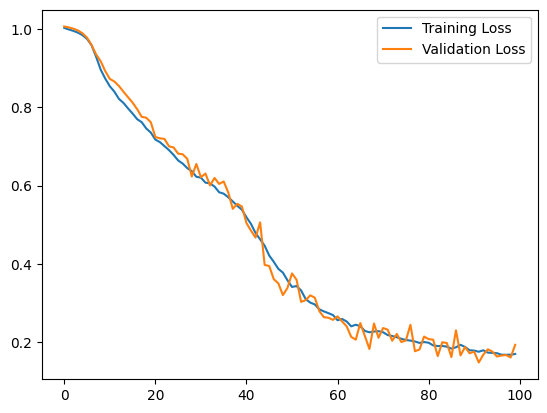

In [36]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## 이상 감지

모델이 입력 데이터를 얼마나 잘 재구성할 수 있는지 결정하여 이상을 감지합니다.

1.   훈련 샘플에서 MAE 손실을 찾습니다.
2.   최대 MAE 손실 값을 찾습니다. 이것은 우리 모델이 샘플을 재구성하기 위해 수행한 최악의 작업입니다. 이를 이상 감지의 `threshold`로 설정합니다.
3.   샘플의 재구성 손실이 이 `threshold` 보다 크면 모델이 익숙하지 않은 패턴을 보고 있다고 추론할 수 있습니다. 우리는 이 샘플을 `anomaly`로 분류할 것입니다.

- MAE 손실 시각화

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


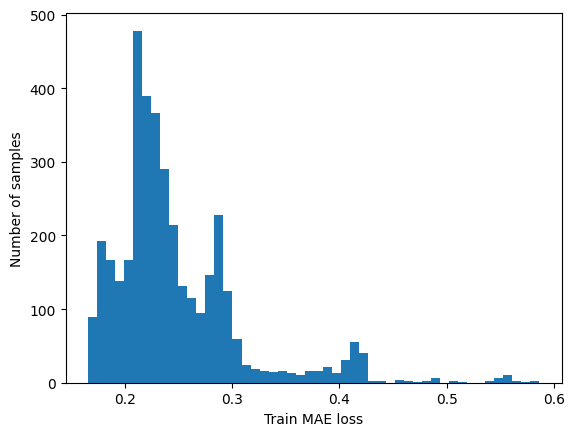

In [37]:
# 모델을 사용하여 훈련 데이터에 대한 예측값을 생성합니다.
X_train_pred = model.predict(X_train)

# 훈련 데이터와 예측값 사이의 MAE(Mean Absolute Error) 손실을 계산합니다.
# np.abs(X_train_pred - X_train)은 절대 오차를 계산합니다.
# np.mean(..., axis=1)은 각 샘플에 대해 평균 절대 오차를 계산합니다.
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# 훈련 데이터의 MAE 손실을 히스토그램으로 시각화합니다.
plt.hist(train_mae_loss, bins=50)

plt.xlabel("Train MAE loss")
plt.ylabel("Number of samples")
plt.show()

- train set의 최대 MAE 손실을 재구성 손실 임계값으로 정합니다.

In [38]:
threshold = np.max(train_mae_loss)
print("재구성 오류 임계값: ", threshold)

재구성 오류 임계값:  0.5863608235416302


### 재구성 비교

우리 모델이 첫 번째 샘플을 어떻게 재구성했는지 봅니다.
이것은 훈련 데이터 세트 1일차의 288개 timestep 입니다.

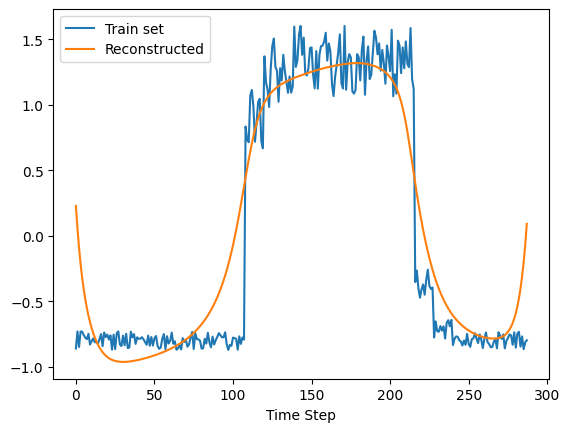

In [39]:
# 첫 번째 시퀀스가  어떻게 학습되었는지 확인
plt.plot(X_train[0], label='Train set')
plt.plot(X_train_pred[0], label='Reconstructed')
plt.xlabel("Time Step")
plt.legend()

### 테스트 데이터 준비
- Test set을 standard scale   
- 분포가 바뀌면 안되므로 Train set 에서 구해 놓았던 평균과 표준 편차를 그대로 사용
- 시각화

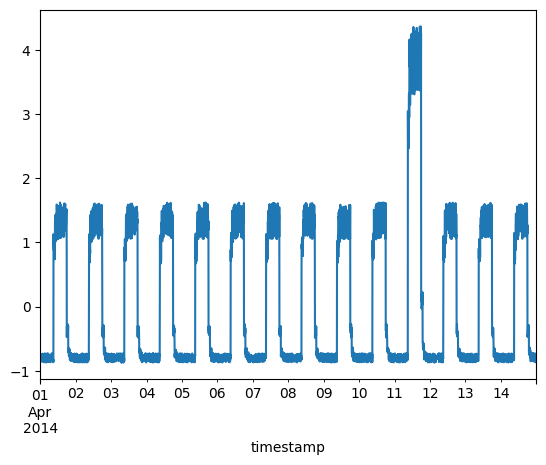

In [40]:
# 테스트 데이터(df_daily_jumpsup)를 표준 정규분포로 변환
df_test_value = (df_daily_jumpsup - training_mean) / training_std

# 그래프를 그리기 위한 Figure와 Axes 객체를 생성합니다.
fig, ax = plt.subplots()

# 표준화된 테스트 데이터(df_test_value)를 플롯합니다.
# legend=False는 범례를 표시하지 않도록 설정합니다.
df_test_value.plot(legend=False, ax=ax)
plt.show()

- Test set에서 시퀀스 data 생성

In [41]:
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

Test input shape:  (3745, 288, 1)


- test set의 MAE loss 구하기

In [42]:
# 모델을 사용하여 테스트 데이터에 대한 예측값을 생성합니다.
x_test_pred = model.predict(x_test)

# 테스트 데이터와 예측값 사이의 MAE(Mean Absolute Error) 손실을 계산합니다.
# np.abs(x_test_pred - x_test)은 절대 오차를 계산합니다.
# np.mean(..., axis=1)은 각 샘플에 대해 평균 절대 오차를 계산합니다.
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)

# 테스트 MAE 손실을 1차원 배열로 변환합니다.
test_mae_loss = test_mae_loss.reshape((-1))
print(test_mae_loss)

118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
[0.22337255 0.22027426 0.21947103 ... 0.22177331 0.22033247 0.21697336]


- MAE 손실 시각화

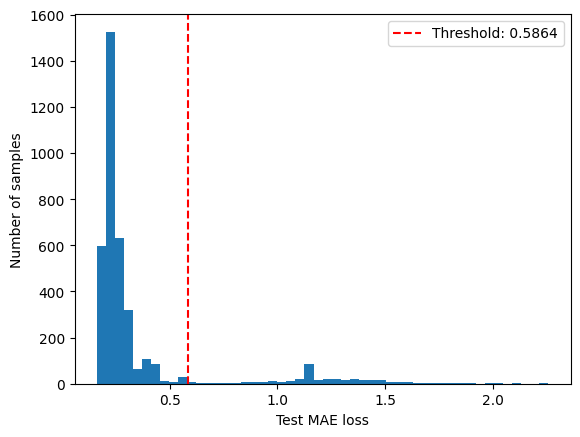

In [43]:
# 테스트 데이터의 MAE 손실을 히스토그램으로 시각화합니다.
plt.hist(test_mae_loss, bins=50)

plt.xlabel("Test MAE loss")
plt.ylabel("Number of samples")

# threshold 값을 수직선으로 표시합니다.
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')

plt.legend()
plt.show()

- 모든 이상 샘플 감지

In [44]:
anomalies = test_mae_loss > threshold
print("이상 감지된 샘플 수: ", np.sum(anomalies))
print("이상 감지된 샘플의 인덱스: ", np.where(anomalies))

이상 감지된 샘플 수:  364
이상 감지된 샘플의 인덱스:  (array([ 108, 1548, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717, 2718,
       2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726, 2727, 2728, 2729,
       2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737, 2738, 2739, 2740,
       2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2749, 2750, 2751,
       2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759, 2760, 2761, 2762,
       2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770, 2771, 2772, 2773,
       2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781, 2782, 2783, 2784,
       2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792, 2793, 2794, 2795,
       2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803, 2804, 2805, 2806,
       2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815, 2816, 2817,
       2818, 2819, 2820, 2821, 2822, 2823, 2824, 2825, 2826, 2827, 2828,
       2829, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2837, 2838, 2839,
       2840, 2841, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2849, 2850,
       2851, 28

## 이상치 plot

이제 우리는 비정상 데이터 샘플을 알고 있습니다. 이를 통해 원본 테스트 데이터에서 해당 `timestamps`를 찾을 수 있습니다. 이를 위해 다음 방법을 사용할 것입니다.

time_steps = 3이고 10개의 훈련 값이 있다고 가정해 보겠습니다. 우리의 `X_train`은 다음과 같이 보일 것입니다:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

초기 및 마지막 time_steps-1 데이터 값을 제외한 모든 값은 `time_steps` 샘플 수로 표시됩니다. 따라서 샘플 [(3, 4, 5), (4, 5, 6), (5, 6, 7)]이 비정상이라는 것을 안다면 데이터 포인트 5가 비정상이라고 말할 수 있습니다.  

그러므로 `TIME_STEPS`기간 전체 샘플 `[(i - timesteps + 1) ~ (i)]`이 비정상인 경우 데이터 `i`는 비정상으로 분류할 수 있습니다.

In [45]:
# 비정상 데이터의 시작 인덱스를 설정합니다.
index = 2754

print(index, index + TIME_STEPS)

# 지정된 인덱스 범위 내의 모든 데이터가 비정상인지 확인합니다.
# anomalies 배열의 'index'부터 'index + TIME_STEPS'까지의 모든 값이 True인지 검사합니다.
# True이면 해당 범위의 모든 데이터가 비정상임을 의미합니다.
result = np.all(anomalies[index: index + TIME_STEPS])

# 결과를 출력합니다. True이면 해당 범위의 모든 데이터가 비정상임을 의미합니다.
print(result)

2754 3042
True


In [47]:
# 이상 데이터의 인덱스를 저장할 리스트를 초기화합니다.
anomalous_data_indices = []

# 데이터의 인덱스를 순회합니다.
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    # 현재 인덱스에서 TIME_STEPS만큼 이전까지의 모든 값이 이상인지 확인합니다.
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        # 모든 값이 이상인 경우, 현재 인덱스를 이상 데이터 인덱스 리스트에 추가합니다.
        anomalous_data_indices.append(data_idx)

# 이상 데이터 인덱스를 출력합니다.
print(anomalous_data_indices)

[2997, 2998, 2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020, 3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042, 3043, 3044, 3045, 3046, 3047, 3048, 3049, 3050, 3051, 3052, 3053, 3054, 3055, 3056, 3057, 3058, 3059, 3060, 3061, 3062, 3063, 3064, 3065, 3066, 3067, 3068, 3069, 3070, 3071, 3072]


원본 테스트 데이터 플롯에 이상치를 오버레이해 시각화

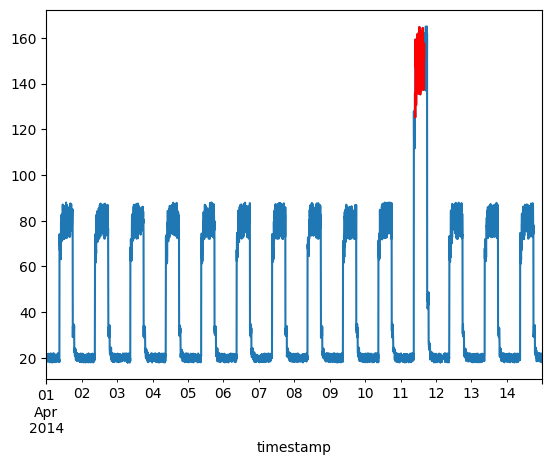

In [48]:
# 이상 데이터의 인덱스를 사용하여 해당하는 부분 데이터프레임을 선택합니다.
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]

# 그래프를 그리기 위한 Figure와 Axes 객체를 생성합니다.
fig, ax = plt.subplots()

# 전체 데이터(df_daily_jumpsup)를 플롯합니다.
# legend=False는 범례를 표시하지 않도록 설정합니다.
df_daily_jumpsup.plot(legend=False, ax=ax)

# 이상 데이터(df_subset)를 플롯합니다.
# legend=False는 범례를 표시하지 않도록 설정합니다.
# color="r"는 이상 데이터를 빨간색으로 표시합니다.
df_subset.plot(legend=False, ax=ax, color="r")

plt.show()